# Final Projects (DS105)
## Bank Turnover Rate

### Problem Statement: <br><br>Project objective is to develop churn prediction model that how likely its current customers will be leaving the bank in near future.


### Download dataset

In [2]:
# import libraries

# For data wrangling
import pandas as pd
import numpy as np

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# store elements as dictionary keys and their counts as dictionary values
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

# display plots in the notebook
%matplotlib inline


In [3]:
# load the dataset

df_bank_cust = pd.read_csv("Churn_Modelling.csv")
df_bank_cust.head().T  # an overview of the dataset

0          1          2         3          4
RowNumber                1          2          3         4          5
CustomerId        15634602   15647311   15619304  15701354   15737888
Surname           Hargrave       Hill       Onio      Boni   Mitchell
CreditScore            619        608        502       699        850
Geography           France      Spain     France    France      Spain
Gender              Female     Female     Female    Female     Female
Age                     42         41         42        39         43
Tenure                   2          1          8         1          2
Balance                0.0   83807.86   159660.8       0.0  125510.82
NumOfProducts            1          1          3         2          1
HasCrCard                1          0          1         0          1
IsActiveMember           1          1          0         0          1
EstimatedSalary  101348.88  112542.58  113931.57  93826.63    79084.1
Exited                   1          0          1         0          0

#### Description of the Attributes from the Dataset

| Attributes      | Description  |
| :-------------- | :------------|
| CreditScore     | the range of credit score is from 350 to 850 |
| Geography       | the regional bank has customers from three countries: France, Germany and Spain |
| Age             | the range of customer’s age is from 18 to 92 |
| Tenure          | years that the customer has stayed with the bank |
| Balance         | the amount of money available for withdrawal |
| NumOfProducts   |  number of products that the customers use in the bank |
| IsActiveMember  | 1 indicates is active |
| EstimatedSalary | customer’s self-reported annual salary |
| Exited          | whether the customer has churned (closed the bank account), 1 indicates churn. |

### Exploratory data analysis

In [4]:
# overview of dataframe to check on data type and null values

df_bank_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
# Missing Observation Analysis

df_bank_cust.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
# Outlier Observation Analysis

for feature in df_bank_cust[['CreditScore','Tenure', 'Balance','EstimatedSalary']]:
    
    Q1 = df_bank_cust[feature].quantile(0.25)
    Q3 = df_bank_cust[feature].quantile(0.75)
    IQR = Q3-Q1
    lower = Q1- 1.5*IQR
    upper = Q3 + 1.5*IQR
    
    if df_bank_cust[(df_bank_cust[feature] > upper)].any(axis=None):
        print(feature,"yes")
    else:
        print(feature, "no")

CreditScore no
Tenure no
Balance no
EstimatedSalary no


In [7]:
# check whether have duplicate values 

df_bank_cust.duplicated().sum()

0

In [8]:
# look for unique value of each column 

df_bank_cust.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

- From the above sanity checks, dataset is clear. There is no "nulls" and no duplicates as all customer IDs are unique in our dataframe. Most important is that there is also no other types of noise in this dataset.
Therefore to make dataframe easily readable, we will drop features that won't be useful in predictive task which there are specific to a customer. It is also borderline with the surname as this would result to profiling. 

In [9]:
# drop features not needed for machine learning

df_bank_cust.drop(["RowNumber","CustomerId","Surname"],axis=1, inplace = True)


# check the updated shape of the dataframe

print(f"Dataframe dimensions: {df_bank_cust.shape}")


# to check again the dataframe after dropping unuseful columns

df_bank_cust.head()  

Dataframe dimensions: (10000, 11)


CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0

- After drop the columns, we still have 11 attributes. 

#### Distributions of Numeric Features

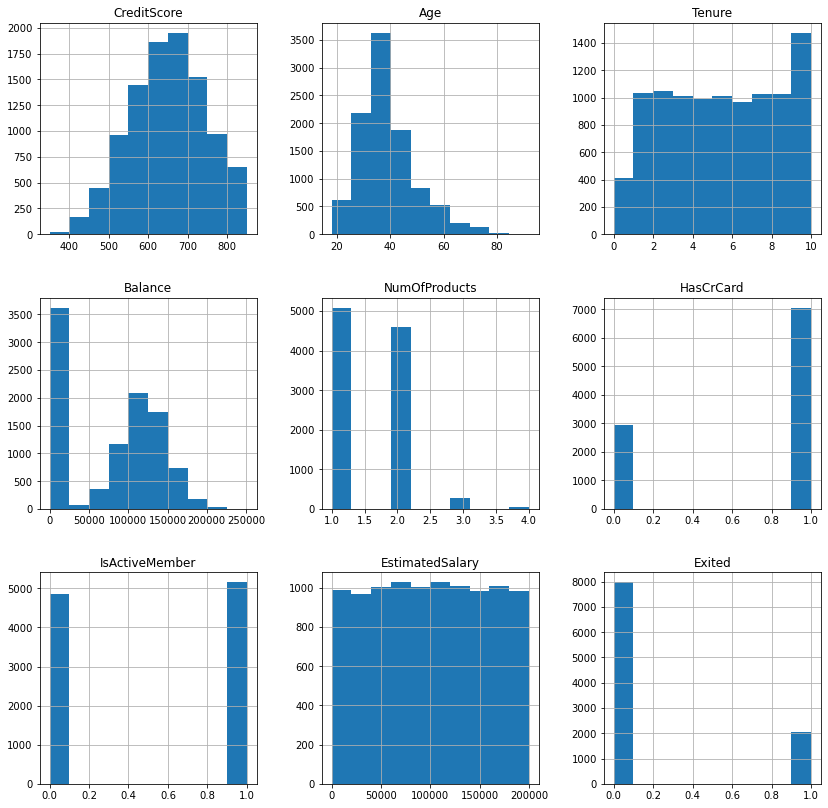

In [10]:
# plot histogram grid

df_bank_cust.hist(figsize=(14,14))

plt.show()

#### Summary statistics for numeric and categorical features

In [11]:
# Summarize numerical features

df_bank_cust.describe().T

count           mean           std     min       25%  \
CreditScore      10000.0     650.528800     96.653299  350.00    584.00   
Age              10000.0      38.921800     10.487806   18.00     32.00   
Tenure           10000.0       5.012800      2.892174    0.00      3.00   
Balance          10000.0   76485.889288  62397.405202    0.00      0.00   
NumOfProducts    10000.0       1.530200      0.581654    1.00      1.00   
HasCrCard        10000.0       0.705500      0.455840    0.00      0.00   
IsActiveMember   10000.0       0.515100      0.499797    0.00      0.00   
EstimatedSalary  10000.0  100090.239881  57510.492818   11.58  51002.11   
Exited           10000.0       0.203700      0.402769    0.00      0.00   

                        50%          75%        max  
CreditScore         652.000     718.0000     850.00  
Age                  37.000      44.0000      92.00  
Tenure                5.000       7.0000      10.00  
Balance           97198.540  127644.2400  250898.09  
NumOfProducts         1.000       2.0000       4.00  
HasCrCard             1.000       1.0000       1.00  
IsActiveMember        1.000       1.0000       1.00  
EstimatedSalary  100193.915  149388.2475  199992.48  
Exited                0.000       0.0000       1.00

In [12]:
# Summarize categorial features

df_bank_cust.describe(include=['O'])

Geography Gender
count      10000  10000
unique         3      2
top       France   Male
freq        5014   5457

In [13]:
#Here we are seeing a lot's person having 0 balance,let's check it.
bal_zero = len(df_bank_cust[df_bank_cust.Balance == 0].Balance)
bal_zero

3617

By looking at the statistics and histograms above, we can conclude that all features look normal and there is no extreme values for any feature. We can also see that in geography, most people are from France and there are more males (5457) than females. There are no sparse classes. 
- Credit Score: Observed that average and median values are overlap and normal distribution.
- Age: Maximum age is 92 however average and median for Age seems close to each to others besides. 
- Tenure: Average and median values almost the same. 
- Balance: Average balance is higher than median value. 
- EstimatedSalary: Outlier status is not observed. Average and median values are considered the same. 
- Here most interest things to notice is 3617 customer of this bank has 0 balance and out of 3617, 3017 didn't exited from the bank.

In [14]:
# to check
df_bank_cust.skew()

CreditScore       -0.071607
Age                1.011320
Tenure             0.010991
Balance           -0.141109
NumOfProducts      0.745568
HasCrCard         -0.901812
IsActiveMember    -0.060437
EstimatedSalary    0.002085
Exited             1.471611
dtype: float64

In [15]:
# to check 
df_bank_cust.kurt()

CreditScore       -0.425726
Age                1.395347
Tenure            -1.165225
Balance           -1.489412
NumOfProducts      0.582981
HasCrCard         -1.186973
IsActiveMember    -1.996747
EstimatedSalary   -1.181518
Exited             0.165671
dtype: float64

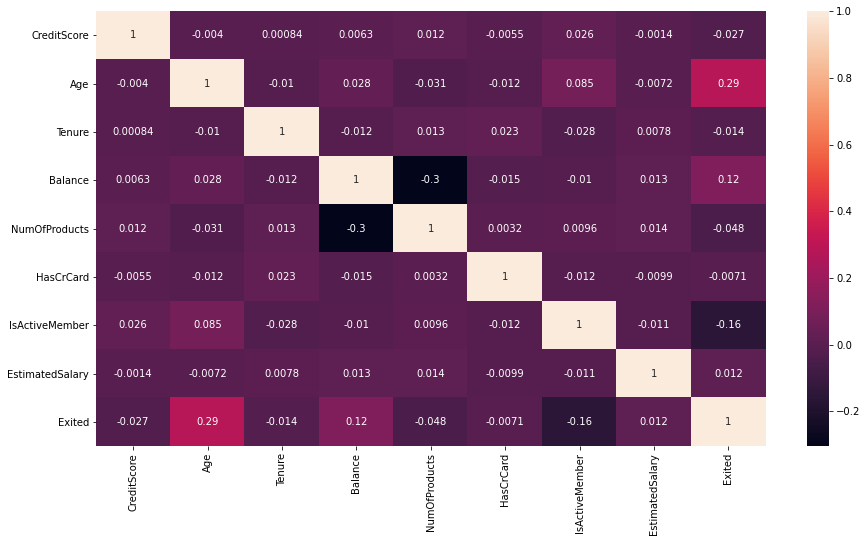

In [16]:
# correlation between variables

plt.figure(figsize=(15,8))
sns.heatmap(df_bank_cust.corr(), annot=True)

plt.show()

- There appears to be very less correlation among all the columns and no multicollinearity which is good. 

In [17]:
#determine categorical and numerical variable

categorical = [col for col in df_bank_cust.columns if df_bank_cust[col].nunique() < 10 
               and col not in "Exited"]

numerical = [col for col in df_bank_cust.columns if df_bank_cust[col].nunique() > 10
            and col not in "Exited"
            and col not in categorical]

In [18]:
# checking after variables grouping

print("Categorical variable: ",categorical)
print("Numerical variable: ",numerical)

Categorical variable:  ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
Numerical variable:  ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']


### Univariate analysis

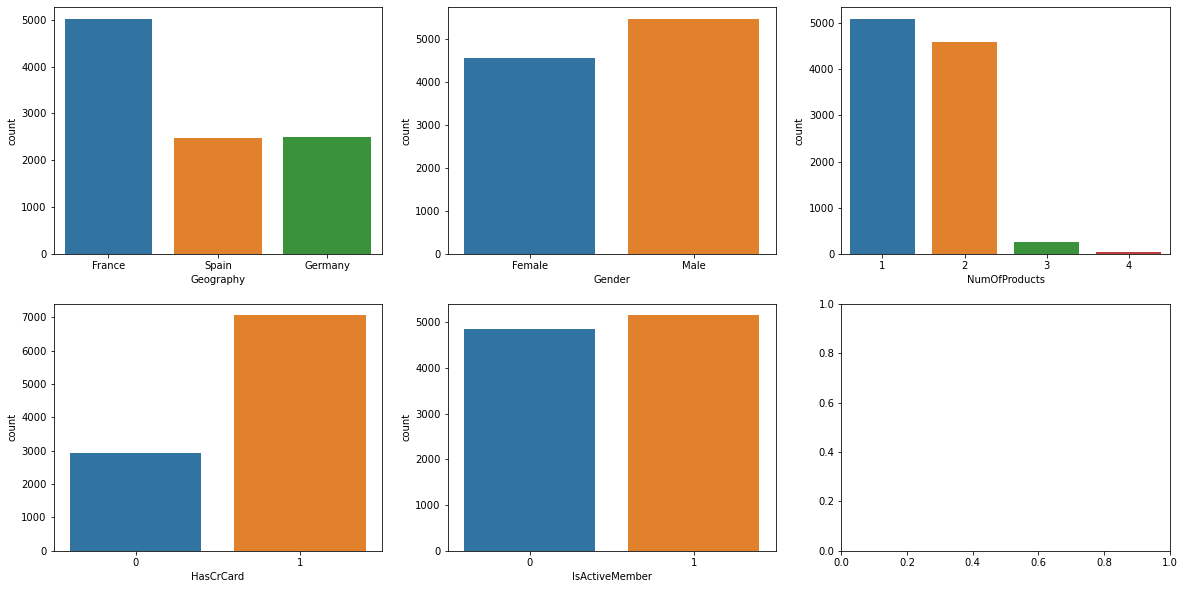

In [19]:
# plot chart for all the categorical variables to explore it from a relatively top view

fig, ax = plt.subplots(2, 3, figsize=(20, 10))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(df_bank_cust[variable], ax=subplot)

In [20]:
# to view on the exact number of each attributes

for col_name in categorical:
    print(col_name)
    print(Counter(df_bank_cust[col_name]))

Geography
Counter({'France': 5014, 'Germany': 2509, 'Spain': 2477})
Gender
Counter({'Male': 5457, 'Female': 4543})
NumOfProducts
Counter({1: 5084, 2: 4590, 3: 266, 4: 60})
HasCrCard
Counter({1: 7055, 0: 2945})
IsActiveMember
Counter({1: 5151, 0: 4849})


In [21]:
# visualize "Geography" with plotly

France = float(df_bank_cust[df_bank_cust['Geography']=='France']['Geography'].count())
Spain = float(df_bank_cust[df_bank_cust['Geography']=='Spain']['Geography'].count())
Germany = float(df_bank_cust[df_bank_cust['Geography']=='Germany']['Geography'].count())
print(France+Spain+Germany)

10000.0


In [22]:
# Easy interact with earth to see the numbers of clients in each country

from chart_studio import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)


data = dict(type='choropleth',
           locations=['ESP','FRA','DEU'],
           colorscale='YlGnBu',
           text = ['Spain','France','Germany'],
           z=[Spain,France,Germany],
           colorbar={'title':'number in each geography'})
layout = dict(title='Counting the numbers of each nationality',
              geo=dict(showframe=False,projection={'type':'natural earth'}))
choromap = go.Figure(data=[data],layout=layout)

In [23]:
iplot(choromap)

Summary from visualisation of categorical features: 
- In our data sample there are more males than females
- Majority of customers are from France, about 50%. Customers from Germany and Spain around 25% each. 

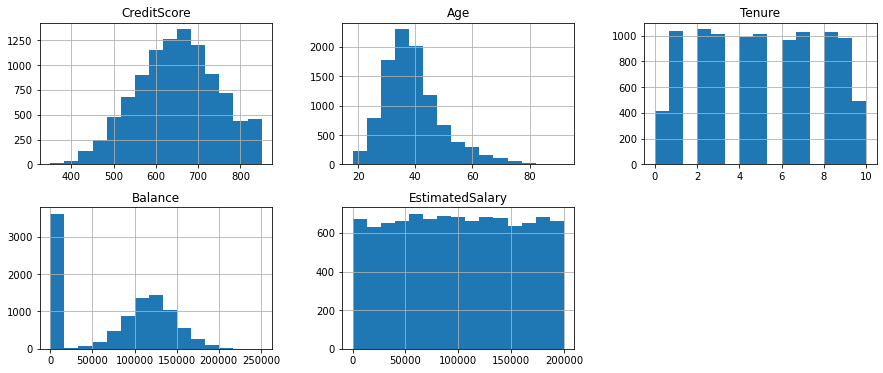

In [24]:
df_bank_cust[numerical].hist(bins=15, figsize=(15, 6), layout=(2, 3))
plt.show()

This feature don't follow a normal distribution. The plot shows that there are less people who stay more than 9 years and many people who stay less than 1 year. 

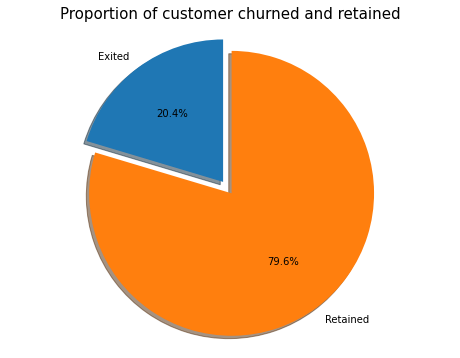

In [25]:
# what is the percentage of churners

labels = 'Exited', 'Retained'
sizes = [df_bank_cust.Exited[df_bank_cust['Exited']==1].count(), df_bank_cust.Exited[df_bank_cust['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(8, 6))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 15)
plt.show()

Here shows that 20.4 % customers churned(leave) from the bank and 79% customers retained.
>0 --> not Exited<br>
>1 --> Exited

So about 20% of the customers have churned. So the baseline model could be to predict that 20% of the customers will churn. Given 20% is a small number, we need to ensure that the chosen model does predict with great accuracy this 20% as it is of interest to the bank to identify and keep this bunch as opposed to accurately predicting the customers that are retained. Generally, it is common to see imbalaced data in Churn and Fraud datasets.

### Bivariate analysis

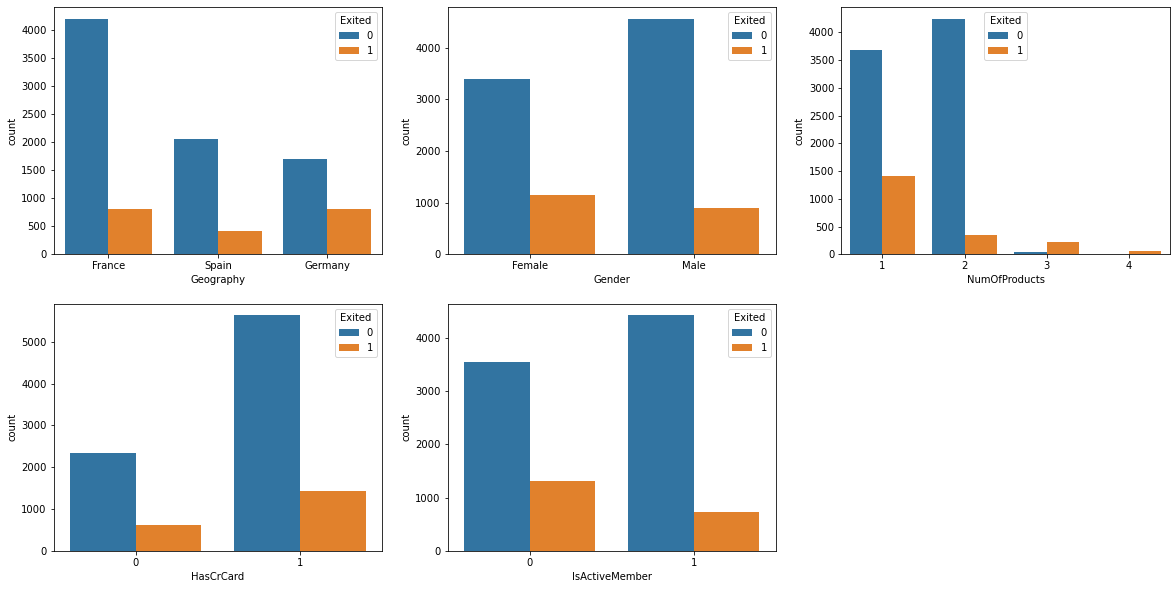

In [26]:
# check on the relation of categorical variable against Exited

plt.figure(figsize=(20,10))

for k in range (0,len(categorical)):
                plt.subplot(2,3,k+1)
                sns.countplot(x=categorical[k], data = df_bank_cust, hue="Exited")         

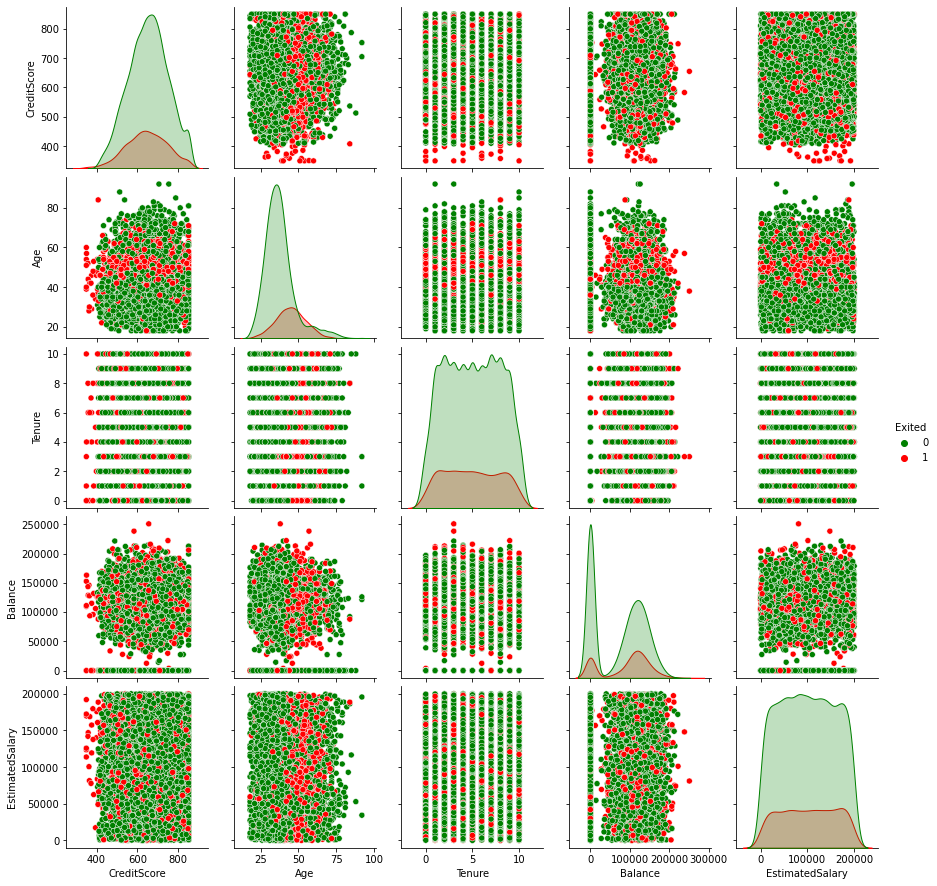

In [27]:
# check on the relation of numerical variable against Exited
      
sns.pairplot(df_bank_cust,hue="Exited",
             vars=['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary'],
             palette={0: "green",
                     1: "red"})
plt.show()

In [28]:
# The distribution of the dependent variable according to the gender variable is plotted in the pie chart.

import plotly.express as px

fig = px.pie(df_bank_cust, values =df_bank_cust.groupby("Gender")["Exited"].value_counts(), 
             names = ["Female,0","Female 1","Male,0","Male,1"])
fig.show()

In [29]:
# Dependent variable was plotted according to age and geography variable.

fig = px.bar(df_bank_cust,y = "Exited", x = "Age" , color = "Geography")
fig.show()

#### Summary of all the deep insights that I have gotten by analysis. 
- Proportion of female customers churning is greater than male customers.
- Majority customers from France but customers in Germany are more likely to churn than customers in France and Spain and their majority people are in the age range between 40 to 50. It is inversely related to the population of customers alluding to the bank possibly having a problem (maybe not enough customer service resources allocated) in the areas where it has fewer clients.
> - As observed, we will see that the top most high peak is age ranging between 30 to 40 in the case of Spain and France and the for Germany's high peak is between 38 to 45 years old. 
> - Most of the senior person are from France. 
- In-active customers are more likely to churn than active (very reasonable). Overall proportion of inactive members is quite high suggesting that the bank may need to implement a program to turn this group to active customers as this will have a positive impact on customer churn.
- Interestingly, majority of the customers that churned are those with credit card hence "HasCrCard" may not be a useful feature as we cannot really tell if a customer has credit card will churn or not.
- Customers in different tenure groups don’t have an apparent tendency to churn or stay.
- Customers who use 3 or 4 product are extremely likely to churn, whereby customers who has 2 products will most likely to stay with the bank. This may due to the hard sales of the bank make the customers feel annoyed on the telemarketing sales. 
- Older customers are churning greater than younger ones. It may due to a difference service preference in the age categories. The bank may need to review their target market or review the service for retention between the different age groups.
> - Age ranging from 30-43 are mostly not to exit from the bank as we can see people who's near 35 and 40 are most in the number not exiting the bank and on the other hand around 40-45 age's people are exited from the bank. 
> - Most noticeable thing is the oldest men in the age ranging bewteen 76 to 80 and non of them are exited from the bank.
- Out of all the customers who have the highest credit score, about 81% of them didn't exit. 
> - Credit score ranging from 600-750 most like not exited from the bank.
- Based on observations above, a third of the customers didn't deposit any money especially almost two third of the customers who are from France are not interest in having balance.
>- Every customer who are from Germany has balance and around 2000 customers had balance greater than 100,000. They are likely to exit from the bank most which means there is strong possibility that they are facing issues while playoing with the money. 


### Data preprocessing

In [30]:
# import machine learing libraries

# data preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler

# hyperparameters tuning, data splitting libraries (support function)
from sklearn.model_selection import train_test_split, GridSearchCV

# machine learning model (fit models)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, \
AdaBoostClassifier,BaggingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import *
import lightgbm as lgb

# evaluation and adjustment of the model (scoring function)
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, \
precision_score, recall_score, accuracy_score, f1_score, log_loss, roc_curve, auc
from yellowbrick.model_selection import feature_importances
import shap


import warnings
warnings.filterwarnings("ignore")


#### Separate dataframe into separate object

In [31]:
# target vector
y = df_bank_cust.Exited

# feature matrix
X = df_bank_cust.drop(columns=["Exited"])

In [32]:
# check on the data whether is balance 

y.value_counts(1)   # imbalanced data

0    0.7963
1    0.2037
Name: Exited, dtype: float64

In [33]:
# check dtype of y 
y.dtypes

dtype('int64')

In [34]:
X.head() # view dataframe

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  
0          1               1        101348.88  
1          0               1        112542.58  
2          1               0        113931.57  
3          0               0         93826.63  
4          1               1         79084.10

The dictionary below tells us what each variable represents and the type of data (float or categorical) it is. If it's categorical, we have to convert it using encoding.


In [35]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
dtypes: float64(2), int64(6), object(2)
memory usage: 781.4+ KB


#### Encoding Categorical Values

In [36]:
# OHE is used for features that turn into 0,1 (since gender and georgraphy are not ordinal)

X = pd.get_dummies(X, columns=["Gender", "Geography"])

X.head().T

0          1          2         3          4
CreditScore           619.00     608.00     502.00    699.00     850.00
Age                    42.00      41.00      42.00     39.00      43.00
Tenure                  2.00       1.00       8.00      1.00       2.00
Balance                 0.00   83807.86  159660.80      0.00  125510.82
NumOfProducts           1.00       1.00       3.00      2.00       1.00
HasCrCard               1.00       0.00       1.00      0.00       1.00
IsActiveMember          1.00       1.00       0.00      0.00       1.00
EstimatedSalary    101348.88  112542.58  113931.57  93826.63   79084.10
Gender_Female           1.00       1.00       1.00      1.00       1.00
Gender_Male             0.00       0.00       0.00      0.00       0.00
Geography_France        1.00       0.00       1.00      1.00       0.00
Geography_Germany       0.00       0.00       0.00      0.00       0.00
Geography_Spain         0.00       1.00       0.00      0.00       1.00

In [37]:
# check on the size originally

sum(y)/len(y)

0.2037

#### Create a Train Test Split

Data will be splitting into train_test using train_test_split() with the test size of 20% of the dataset. As the dataset is imbalance hence we use stratify method to split the dataset equally. 

In [38]:
# Stratified splitting: set stratify=y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42, stratify=y)

In [39]:
# check on the train test is split equally same as orginally y to avoid any imbalance data

sum(y_train)/len(y_train)

0.20375

In [40]:
# check on the test set is split equally same as originally to avoid any imbalance data

sum(y_test)/len(y_test)

0.2035

In [41]:
# check on "y" data types and ensure it is in numerical

y_train.dtypes

dtype('int64')

In [42]:
# make sure train test split shape is all the same

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 13) (2000, 13) (8000,) (2000,)


In [43]:
# make a copy before scaling

X_train_scale = X_train.copy()
X_test_scale = X_test.copy()

- Stratify worked as expected and both y_train and y_test have the same percentage of people that defaulted. Now let's build the preliminary model.

- Remember that we are dealing with an unbalanced dataset hence to manage the situation, we'll standardize the features of the training set using StardardScaler.

#### Feature Scaling

In [44]:
# scale columns that have huge rage which is more than 10

sc = StandardScaler()

ss_col = ["CreditScore","Balance","EstimatedSalary"]

for item in ss_col:
    X_train_scale[item] = sc.fit_transform(X_train[[item]])
    X_test_scale[item] = sc.fit_transform(X_test[[item]])

In [45]:
# view dataframe after scaling

X_train_scale.head().T

2151       8392       5006       4117       7182
CreditScore         1.058568   0.913626   1.079274  -0.929207   0.427035
Age                57.000000  32.000000  37.000000  37.000000  49.000000
Tenure              7.000000   3.000000   0.000000   5.000000   6.000000
Balance            -1.226059   0.413288   0.601687  -1.226059   0.548318
NumOfProducts       1.000000   1.000000   2.000000   2.000000   2.000000
HasCrCard           1.000000   1.000000   1.000000   1.000000   0.000000
IsActiveMember      0.000000   0.000000   1.000000   0.000000   1.000000
EstimatedSalary     1.042084  -0.623556   0.308128  -0.290199   0.135042
Gender_Female       0.000000   0.000000   1.000000   0.000000   0.000000
Gender_Male         1.000000   1.000000   0.000000   1.000000   1.000000
Geography_France    1.000000   0.000000   0.000000   1.000000   0.000000
Geography_Germany   0.000000   1.000000   1.000000   0.000000   1.000000
Geography_Spain     0.000000   0.000000   0.000000   0.000000   0.000000

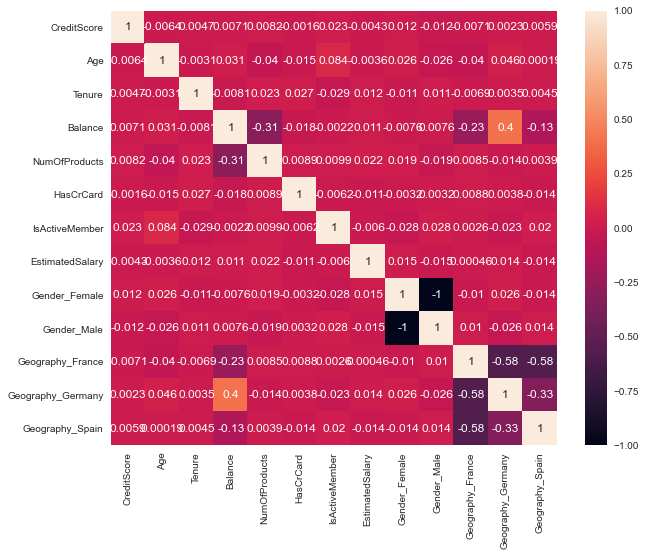

In [46]:
# multicollinearity check after encoding and scaler

cor = X_train_scale.corr()

plt.figure(figsize=(10,8))
sns.heatmap(cor,annot=True)
plt.show()

- From the heatmap, there is no high correlated features hence no column need to be drop after scaling.
- Now the data is standardized and balanced. 

### Model Selection and trainings

Our task is a binary classification problem with imbalanced classes. We will be using lazy prediction have a baseline model testing and select the best according to it's performance (score, speed). Instead of using accuracy as one of the validation metrics, we'll reference to F1 score or AUC to determine the best model for tuning.<br><br>It's easy to achieve a good accuracy by predicting only "No" while AUC will be more relevant by taking into account the False Positive Rate and True Positive Rate. AUC score is the Area Under ROC curve, a score close to 1 means that we have a good model. The curve is drawn by computing true positive rate against false positive rate for various tresholds.<br><br>F1-score is the same that the score reaches its best value at 1 and worst score at 0. The F1 score can be interpreted as a weighted average of the precision and recall and the relative contribution of precision and recall to F1 score are equal. To evaluate the effectiveness of these models, we could use Precision or Recall. Precision will give us the proportion of positive identifications that were indeed correct, while recall will determine the proportion of real positives that were correctly identified.

Considering the problem we are trying to solve, Recall will be more suitable for this study, as the objective here is to identify the maximum number of clients that are actually prone to stop doing business with the company, even if some "non-churners" are wrongly identified as "churners". That is to say, in our case, it is better to pursue a smaller number of False Negatives possible.


In [47]:
# import libraries (using lazy prediction to have a high level check on which model are more accurate)
import lazypredict
from lazypredict.Supervised import LazyClassifier

##### How lazy predict's parameters work

>- verbose: int data type, if non zero, progress messages are printed. Above 50, the output is sent to stdout. The frequency of the messages increases with the verbosity level. If it more than 10, all iterations are reported. I would suggest you try different values based on your depth of analysis.
>- predictions: boolean data type if it is set to True then it will return all the predicted values from the models. 

#### classic will return two values:
>- models: will have all the models and with some metrics
>- predictions: will have all the predicted values that is ŷ

In [48]:
# perform lazy prediction to fit and train all models

reg = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None,predictions=True)
models,predictions = reg.fit(X_train_scale, X_test_scale, y_train, y_test)


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:12<00:00,  2.38it/s]


In [49]:
# print the results from lazy prediction and check which model did better on the dataset

models

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
XGBClassifier                      0.85               0.71     0.71      0.84   
AdaBoostClassifier                 0.85               0.71     0.71      0.84   
LGBMClassifier                     0.86               0.71     0.71      0.84   
BaggingClassifier                  0.85               0.71     0.71      0.84   
RandomForestClassifier             0.86               0.70     0.70      0.84   
ExtraTreesClassifier               0.85               0.69     0.69      0.84   
DecisionTreeClassifier             0.79               0.69     0.69      0.79   
SVC                                0.86               0.69     0.69      0.84   
LabelSpreading                     0.80               0.68     0.68      0.79   
NearestCentroid                    0.69               0.67     0.67      0.72   
LabelPropagation                   0.79               0.67     0.67      0.79   
QuadraticDiscriminantAnalysis      0.79               0.67     0.67      0.79   
GaussianNB                         0.81               0.65     0.65      0.79   
KNeighborsClassifier               0.82               0.65     0.65      0.80   
ExtraTreeClassifier                0.77               0.64     0.64      0.77   
BernoulliNB                        0.79               0.61     0.61      0.77   
PassiveAggressiveClassifier        0.71               0.59     0.59      0.72   
Perceptron                         0.73               0.59     0.59      0.73   
LinearDiscriminantAnalysis         0.80               0.58     0.58      0.77   
LogisticRegression                 0.81               0.58     0.58      0.77   
CalibratedClassifierCV             0.81               0.57     0.57      0.76   
LinearSVC                          0.81               0.56     0.56      0.76   
RidgeClassifierCV                  0.81               0.55     0.55      0.75   
RidgeClassifier                    0.81               0.55     0.55      0.75   
SGDClassifier                      0.80               0.54     0.54      0.74   
DummyClassifier                    0.67               0.49     0.49      0.67   

                               Time Taken  
Model                                      
XGBClassifier                        0.42  
AdaBoostClassifier                   0.35  
LGBMClassifier                       0.17  
BaggingClassifier                    0.25  
RandomForestClassifier               0.92  
ExtraTreesClassifier                 0.69  
DecisionTreeClassifier               0.06  
SVC                                  1.25  
LabelSpreading                       3.13  
NearestCentroid                      0.02  
LabelPropagation                     2.39  
QuadraticDiscriminantAnalysis        0.03  
GaussianNB                           0.02  
KNeighborsClassifier                 0.25  
ExtraTreeClassifier                  0.03  
BernoulliNB                          0.02  
PassiveAggressiveClassifier          0.03  
Perceptron                           0.02  
LinearDiscriminantAnalysis           0.05  
LogisticRegression                   0.03  
CalibratedClassifierCV               1.44  
LinearSVC                            0.46  
RidgeClassifierCV                    0.03  
RidgeClassifier                      0.03  
SGDClassifier                        0.06  
DummyClassifier                      0.02

In [50]:
# print the prediction from lazy prediction

predictions

AdaBoostClassifier  BaggingClassifier  BernoulliNB  \
0                      0                  0            0   
1                      0                  0            0   
2                      0                  0            0   
3                      0                  0            0   
4                      0                  0            0   
...                  ...                ...          ...   
1995                   0                  0            0   
1996                   0                  0            0   
1997                   1                  1            1   
1998                   0                  0            0   
1999                   0                  0            0   

      CalibratedClassifierCV  DecisionTreeClassifier  DummyClassifier  \
0                          0                       0                0   
1                          0                       0                1   
2                          0                       0                0   
3                          0                       0                0   
4                          0                       0                0   
...                      ...                     ...              ...   
1995                       0                       0                0   
1996                       0                       0                1   
1997                       1                       1                0   
1998                       0                       0                0   
1999                       0                       0                0   

      ExtraTreeClassifier  ExtraTreesClassifier  GaussianNB  \
0                       0                     0           0   
1                       0                     0           0   
2                       0                     0           0   
3                       0                     0           0   
4                       1                     0           0   
...                   ...                   ...         ...   
1995                    1                     0           0   
1996                    0                     0           0   
1997                    1                     1           1   
1998                    0                     0           0   
1999                    1                     0           0   

      KNeighborsClassifier  ...  PassiveAggressiveClassifier  Perceptron  \
0                        0  ...                            0           0   
1                        0  ...                            1           0   
2                        0  ...                            0           0   
3                        0  ...                            1           0   
4                        0  ...                            0           0   
...                    ...  ...                          ...         ...   
1995                     0  ...                            0           0   
1996                     0  ...                            1           1   
1997                     1  ...                            0           0   
1998                     0  ...                            0           0   
1999                     0  ...                            0           0   

      QuadraticDiscriminantAnalysis  RandomForestClassifier  RidgeClassifier  \
0                                 0                       0                0   
1                                 0                       0                0   
2                                 0                       0                0   
3                                 0                       0                0   
4                                 0                       0                0   
...                             ...                     ...              ...   
1995                              0                       0                0   
1996                              0                       0                0   
1997              

In [51]:
models.head(8)

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                    
XGBClassifier               0.85               0.71     0.71      0.84   
AdaBoostClassifier          0.85               0.71     0.71      0.84   
LGBMClassifier              0.86               0.71     0.71      0.84   
BaggingClassifier           0.85               0.71     0.71      0.84   
RandomForestClassifier      0.86               0.70     0.70      0.84   
ExtraTreesClassifier        0.85               0.69     0.69      0.84   
DecisionTreeClassifier      0.79               0.69     0.69      0.79   
SVC                         0.86               0.69     0.69      0.84   

                        Time Taken  
Model                               
XGBClassifier                 0.42  
AdaBoostClassifier            0.35  
LGBMClassifier                0.17  
BaggingClassifier             0.25  
RandomForestClassifier        0.92  
ExtraTreesClassifier          0.69  
DecisionTreeClassifier        0.06  
SVC                           1.25

From lazy prediction results above, the top 8 models will be used and we'll determine which one shows the better results of logloss: 
- XGBClassifier
- AdaBoostClassifier
- LGBMClassifier
- BaggingClassifier
- RandomForestClassifier
- ExtraTreesClassifier
- DecisionTreeClassifier
- SVC (Support Vector Classifier)

As the metrics are all quite close and makes it hard to compare which is a better model hence we proceed to have log loss for comparison. Log loss will be telling us how confident that we are in predicting the correct label. The lower the loss, the better model is. 



In [52]:
# create dataframe and for loop to fit 8 models into the training set and check the log loss of each model with other metircs results

combine_results = pd.DataFrame(columns=["model", "roc", "logloss", "accuracy", "precision", "recall", "f1_score"])

test_model = {"AdaBoost":AdaBoostClassifier(), "RandomForest":RandomForestClassifier(), "XGBoost":XGBClassifier(),\
              'SVC':SVC(), "lgbm":LGBMClassifier(), "DecisionTrees":DecisionTreeClassifier(),\
              "ExtraTrees":ExtraTreesClassifier(),"Bagging":BaggingClassifier()}

counter = 0
for a, model in test_model.items():
    base_model = model.fit(X_train_scale, y_train)
    model_result = base_model.predict(X_test_scale)
    combine_results.loc[counter, :] = a, roc_auc_score(y_test , model_result), log_loss(y_test, model_result), \
    accuracy_score(y_test,model_result), precision_score(y_test,model_result), recall_score(y_test,model_result),\
    f1_score(y_test,model_result)
    counter += 1

print (combine_results)


           model  roc logloss accuracy precision recall f1_score
0       AdaBoost 0.71    5.01     0.85      0.72   0.48     0.57
1   RandomForest 0.71    4.84     0.86      0.76   0.46     0.57
2        XGBoost 0.71    5.18     0.85      0.69   0.49     0.57
3            SVC 0.50    7.03     0.80      0.00   0.00     0.00
4           lgbm 0.71    4.94     0.86      0.73   0.47     0.57
5  DecisionTrees 0.69    7.29     0.79      0.48   0.53     0.50
6     ExtraTrees 0.69    5.04     0.85      0.76   0.42     0.54
7        Bagging 0.70    5.06     0.85      0.73   0.45     0.56


- From the baseline model testing, we have tried 8 different models and evaluate the outputs. Utlimately we are going to be moving forward with RandomForest,LGBM and AdaBoost which are the top 3 best model among all other models based on the metrics - log loss. Hence, we proceed to have hyperparameter tuning for this 3 models. 

### Hyperparameter optimization

To optimize the parameters we will use GridSearch, an exhaustive search with a selected subset of relevant hyperparameters. Scikit-learn has a library specially dedicated to this task : GridSearchCV, we will use it with 5-fold cross-validation.

#### 1.  Random Forest Classifier

In [53]:
# Fitting Random Forest Classification to the Training set
# random state is important to set if you want to produce the same results, to ensure bootstrapping is same

base_rf = RandomForestClassifier(random_state = 42,class_weight="balanced")

- We are using "class_weight" as one of the parameters to adjust the weight of target. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

In [54]:
# set the parameters for tuning
# n estimators = The number of trees in the forest.
# criterion = the function to measure the quality of a split. 
# max_depth = the maximum depth of the tress.

param_dict1 = { 
               "max_depth" : [24,25,26,27,28], 
               "criterion": ['gini','entropy'],
               "n_estimators": [90,100,110,120,130]}

In [55]:
# fitting the parameters for tuning

grid_model_rf = GridSearchCV(estimator= base_rf, param_grid = param_dict1 , cv=5 , verbose= 1)

In [56]:
# fit the training set after tuning

grid_model_rf.fit(X_train_scale, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  3.4min finished


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [24, 25, 26, 27, 28],
                         'n_estimators': [90, 100, 110, 120, 130]},
             verbose=1)

In [57]:
# to get the best parameters

grid_model_rf.best_params_

{'criterion': 'entropy', 'max_depth': 26, 'n_estimators': 110}

__Parameters' adjustment__

Attempt 1:
> max_depth:
    2, 3, 4, 5 return 5 as the best<br>
> n_estimors: 
    10, 50, 100 return 50 as the best

Attempt 2:
> max_depth:
    5, 10, 15, 20, 25 return 25 as the best<br>
> n_estimors: 
    30, 40, 50, 60, 70 return 70 as the best

Attempt 3:
> max_depth:
    23,25,30,35,40 return 25 as the best<br>
> n_estimors: 
    80,90,100,110,120 return 110 as the best


Attempt 4:
> max_depth:
    24,25,26,27,28 return 26 as the best<br>
> n_estimors: 
    70,100,130,160,190 return 100 as the best

Attempt 5:
> max_depth:
    24,25,26,27,28 return 26 as the best<br>
> n_estimors: 
    90,100,110,120,130 return 110 as the best
    

- The best parameters for Random Forest algorithm at {"max_depth": 26, "n_estimators": 110}, using "n_estimators": [90,100,110,120,130] , "max_depth": [24,25,26,27,28].

In [58]:
# using the best parameters to predict on test set and check on the log loss and ROC

y_pred_rf = grid_model_rf.predict(X_test_scale)
print("Log loss of tuned:", log_loss(y_test, y_pred_rf))
print("ROC of tuned:",roc_auc_score(y_test, y_pred_rf))

Log loss of tuned: 4.956338800391304
ROC of tuned: 0.7032124574497456


In [59]:
# check on metrics results

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1593
           1       0.75      0.44      0.56       407

    accuracy                           0.86      2000
   macro avg       0.81      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000



In [60]:
# comparison of the metrics results before tune
combine_results.iloc[[1]]

model  roc logloss accuracy precision recall f1_score
1  RandomForest 0.71    4.84     0.86      0.76   0.46     0.57

#### Model Evaluation and Visualisation

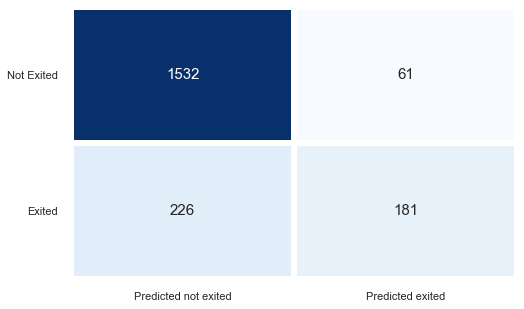

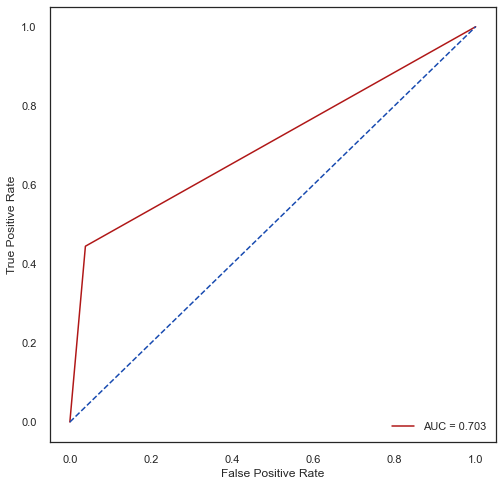

In [93]:
#visualise confusion matrix

cm_rf = confusion_matrix(y_test,y_pred_rf)
plt.figure(figsize = (8, 5))
sns.heatmap(cm_rf, cmap = "Blues", annot = True, fmt = "d", linewidths = 5, cbar = False, annot_kws = {"fontsize": 15},
           yticklabels = ["Not Exited", "Exited"], xticklabels = ["Predicted not exited", "Predicted exited"])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_rf)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = "white")
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = "#b01717", label = "AUC = %0.3f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0, 1], [0, 1], linestyle = "--", color = "#174ab0")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()


In [62]:
# Feature importance

f_imp2 = pd.DataFrame(columns = ["feature", "importance"], index = range(13))
for i in range(len(f_imp2.index)):
    f_imp2.iloc[i,0] = X_train_scale.columns.to_list()[i]
f_imp2["importance"] = grid_model_rf.best_estimator_.feature_importances_
f_imp2 = f_imp2.sort_values("importance", ascending = False)
f_imp2[0:12].style.background_gradient(cmap = "Blues")

- Based on model Random Forest, we can see that the attributes "Age" is the most important feature to determine whether the client churn or not following by the client's estimated salary and balance have with the bank.

In [63]:
# using SHAP to build explanation and compute the feature importance
# TreeExplainer -> Uses Tree SHAP algorithms to explain the output of ensemble tree models.

explainer = shap.TreeExplainer(grid_model_rf.best_estimator_)
shap_values = explainer.shap_values(X_test_scale)

SHAP start the analisys from a 'baseline' in terms of class prediction.

expected_value return our baselines and from there we see the impact of our features.

> This is the reference value that the feature contributions start from. For SHAP values it should be the value of explainer.expected_value.
> ###### SHAP
HAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions (see papers for details and citations).

In [64]:
print(explainer.expected_value)

[0.49984134 0.50015866]


The expected_value is an array with 2 floats: where the size of the array means our classes 0 and 1 (binary) and the float number itself means the probability of class N.

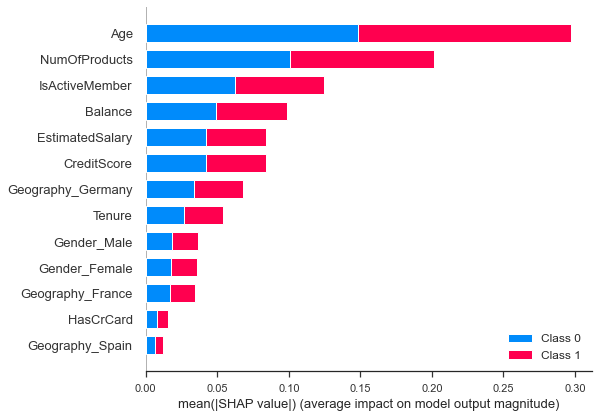

In [65]:
# plot the importances (chart will be easier to interpret than values)

shap.summary_plot(shap_values, X_test_scale, plot_type="bar")

In [66]:
# plot possibilites (Probability to be class 0)
#visualise all the training set predictions

shap.initjs() 
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test_scale)

In [67]:
# Probability to be class 1

shap.force_plot(explainer.expected_value[1], shap_values[1], X_test_scale)

##### Observation: 

Although we get the best parameter for tuning after 5 attempts to train the model, there is no huge discrepany or improvement for the metric results.<br>
Based on confusion matrix, it has the lowest count of true positive compare to other models. We are looking for customers who are likely to churn hence recall score to us is still important and Random Forest have the lowest recall score among 3 models, <br>
Age is the most important feature in Random Forest Classifier.

#### 2. LGBM Classifier

In [68]:
# fit the training set into LGBMClassifier
# using "is_balance" paramaters for imbalance dataset 

base_model_lgbm = LGBMClassifier(random_state=42, is_unbalance=True)

In [69]:
# set paramater range to get the best

param_dict_lgbm = {"n_estimators" : [395, 400, 410, 415, 420],  
                 "learning_rate" : [0.20, 0.25, 0.30, 0.35, 0.40],
                  "max_depth": [10,20,30,40,50]}

In [70]:
# hyperparameter tuning

grid_model_lgbm = GridSearchCV(param_grid= param_dict_lgbm , 
                             estimator= base_model_lgbm , cv= 5 , verbose=1)

In [71]:
grid_model_lgbm.fit(X_train_scale , y_train)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 625 out of 625 | elapsed:  6.4min finished


GridSearchCV(cv=5, estimator=LGBMClassifier(is_unbalance=True, random_state=42),
             param_grid={'learning_rate': [0.2, 0.25, 0.3, 0.35, 0.4],
                         'max_depth': [10, 20, 30, 40, 50],
                         'n_estimators': [395, 400, 410, 415, 420]},
             verbose=1)

In [72]:
# to get best parameters

grid_model_lgbm.best_params_

{'learning_rate': 0.3, 'max_depth': 20, 'n_estimators': 410}

__Parameters' adjustment__

Attempt 1:
> max_depth:
    30,40,50,60,70 return 30 as the best<br>
> n_estimors: 
    380, 390, 400, 410, 420 return 410 as the best<br>
> learning_rate: 
    0.26, 0.27, 0.28, 0.29, 0.30 return 0.3 as the best
    
Attempt 2:
> max_depth:
    10,20,30,40,50 return 20 as the best<br>
> n_estimors: 
    395, 400, 410, 415, 420 return 410 as the best<br>
> learning_rate: 
   0.20, 0.25, 0.30, 0.35, 0.40 return 0.3 as the best
   
- The best parameters for LGBM algorithm at {'learning_rate': 0.30, 'max_depth': 20, 'n_estimators': 410}, using "n_estimators": [395, 400, 410, 415, 420] , "max_depth": [10, 20, 30, 40, 50],"learning_rate":[0.2, 0.25, 0.3, 0.35, 0.4]

In [73]:
# using the best parameters to predict on test set and check on the log loss and ROC

y_pred_lgbm = grid_model_lgbm.predict(X_test_scale)
print("Log loss of tuned:", log_loss(y_test, y_pred_lgbm))
print("ROC of tuned:",roc_auc_score(y_test, y_pred_lgbm))

Log loss of tuned: 5.543525585216128
ROC of tuned: 0.7245527499764788


In [74]:
# check on metrics results

print(classification_report(y_test, y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1593
           1       0.62      0.53      0.57       407

    accuracy                           0.84      2000
   macro avg       0.75      0.72      0.74      2000
weighted avg       0.83      0.84      0.83      2000



In [75]:
# comparison of the metrics results before tune
combine_results.iloc[[4]]

model  roc logloss accuracy precision recall f1_score
4  lgbm 0.71    4.94     0.86      0.73   0.47     0.57

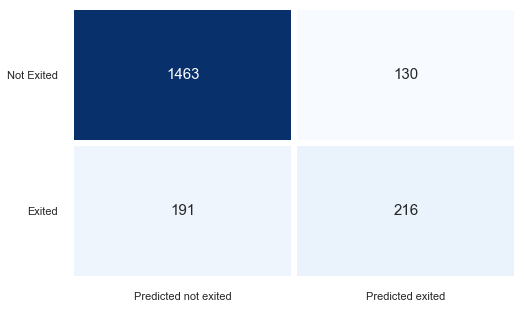

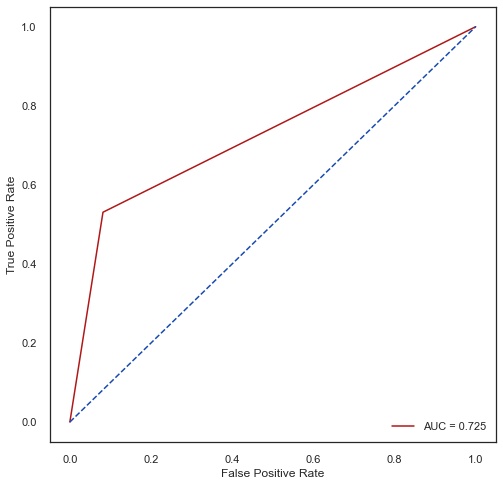

In [91]:
#visualise confusion matrix

cm_lgbm = confusion_matrix(y_test,y_pred_lgbm)
plt.figure(figsize = (8, 5))
sns.heatmap(cm_lgbm, cmap = "Blues", annot = True, fmt = "d", linewidths = 5, cbar = False, annot_kws = {"fontsize": 15},
           yticklabels = ["Not Exited", "Exited"], xticklabels = ["Predicted not exited", "Predicted exited"])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_lgbm)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = "white")
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = "#b01717", label = "AUC = %0.3f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0, 1], [0, 1], linestyle = "--", color = "#174ab0")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

In [77]:
# plot feature importance for LighBGM algorithm 

def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({"Percentage":(model.feature_importance() / sum(model.feature_importance())) * 100,
                                "Feature":X.columns})
    plt.figure(figsize=(40,20))
    sns.set(font_scale = 4)
    sns.barplot(x="Percentage", y="Feature", data=feature_imp.sort_values(by="Percentage", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

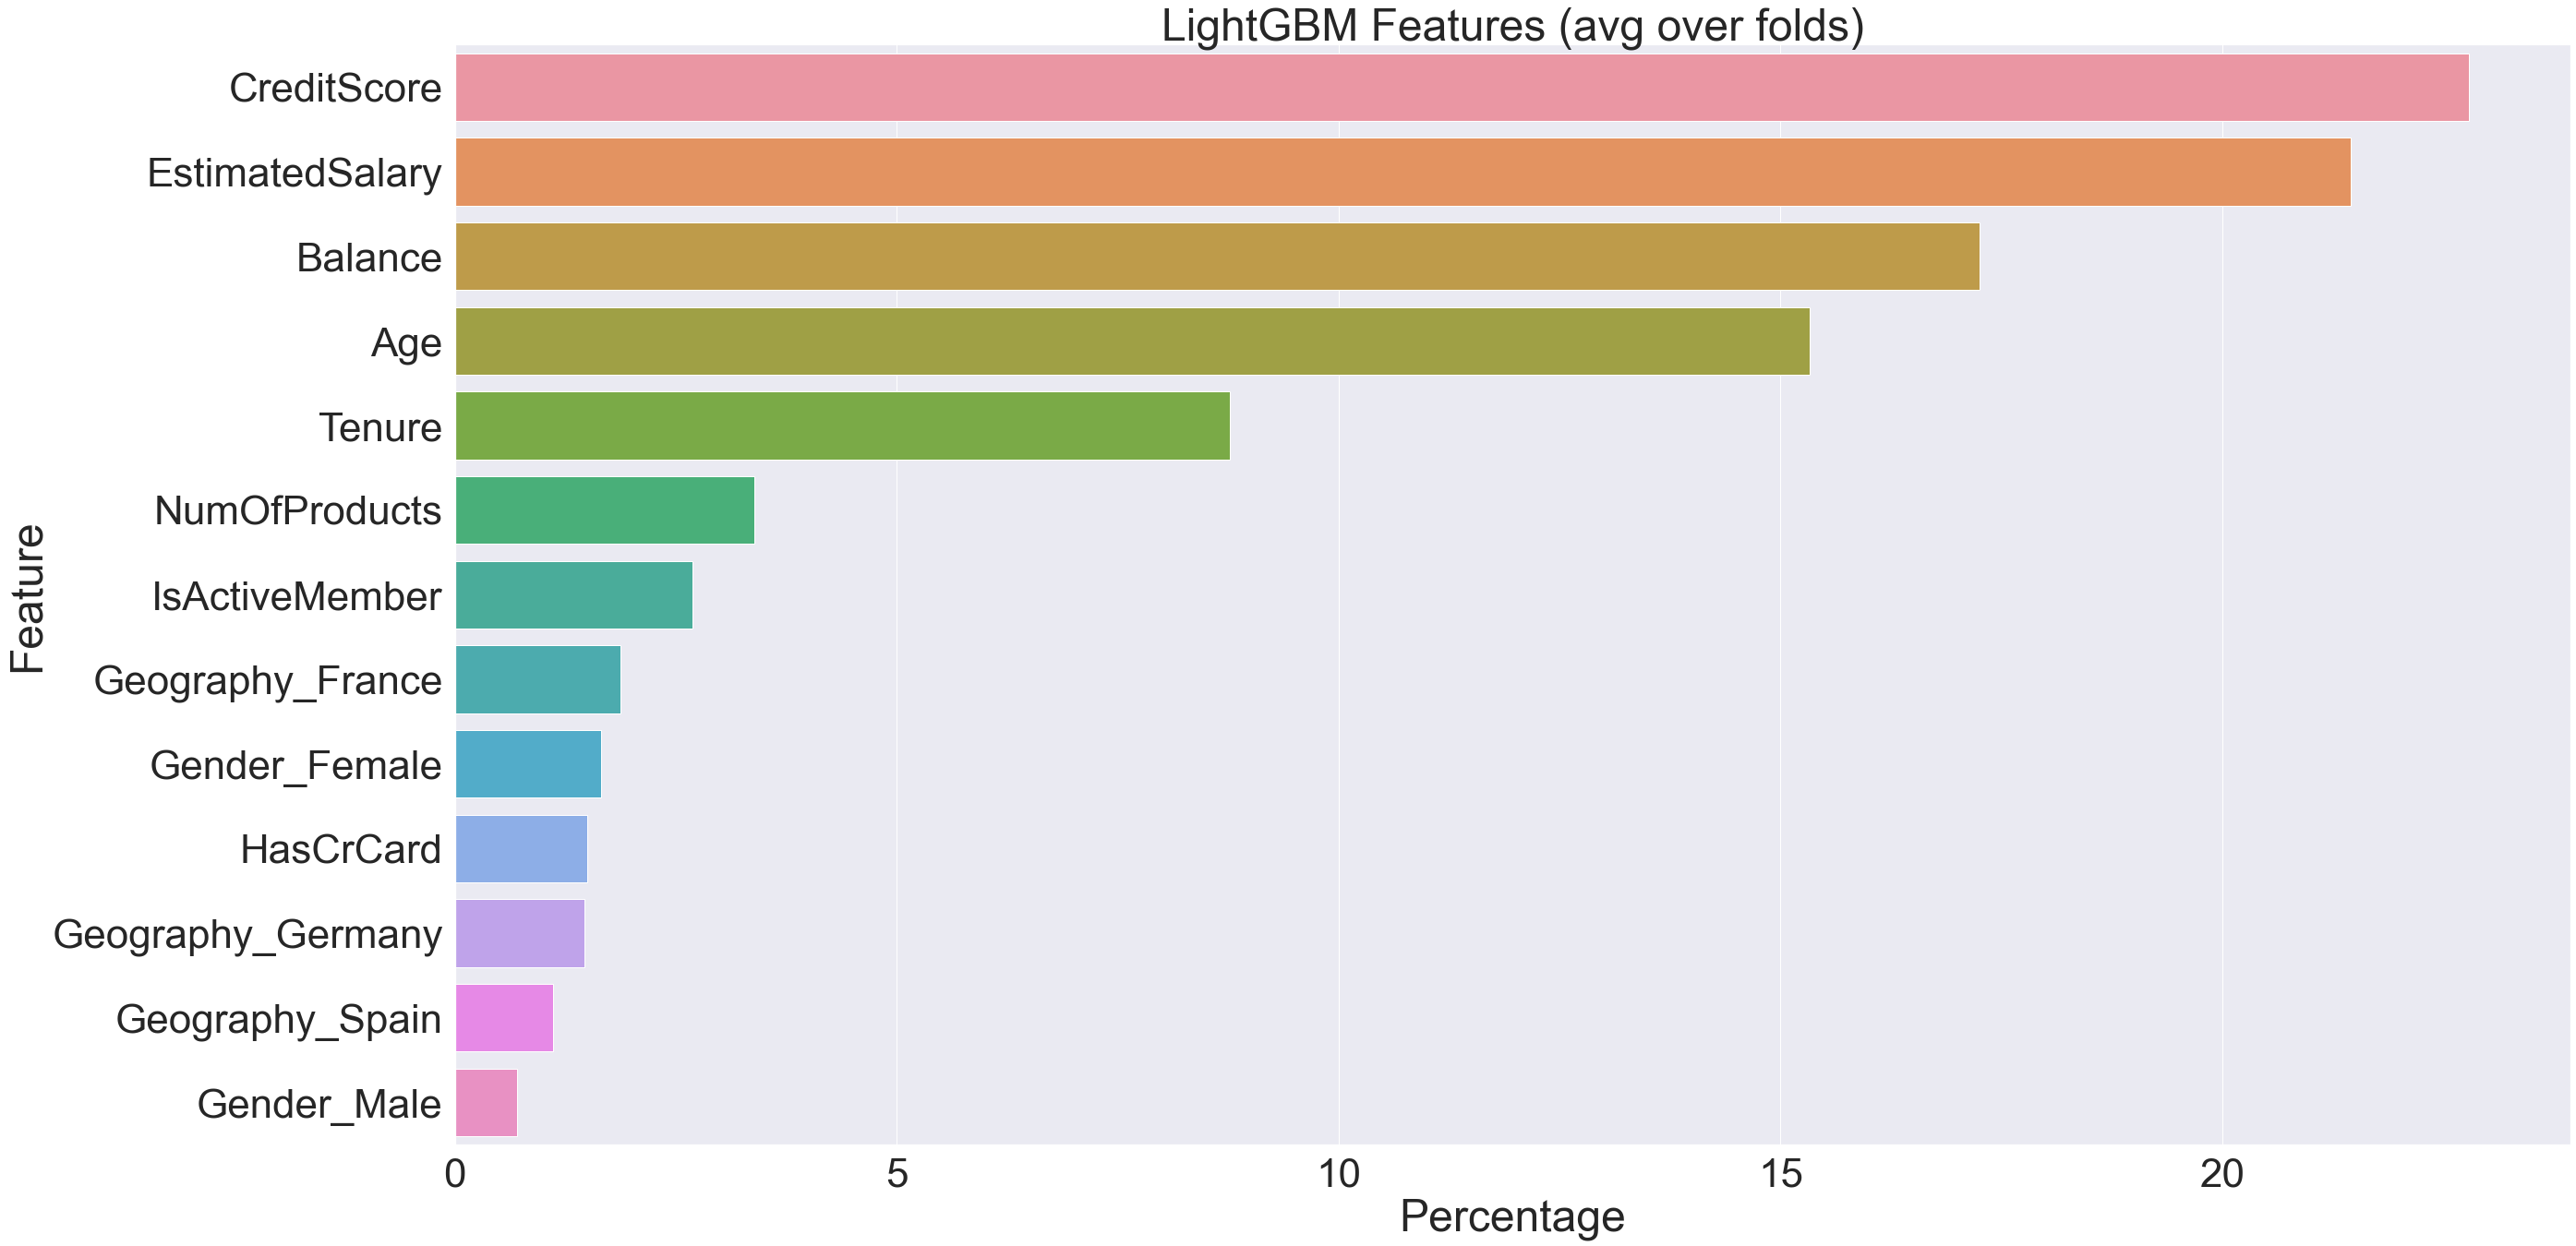

In [78]:
plotImp(grid_model_lgbm.best_estimator_.booster_,X_train_scale)

##### Observation: 

Although we have chosen LGBM classifier for tuning as one of the top 3 models, the results is not shown the best metrics after tuning. 
We have tried 2 attempts to get the best parameters and handle imbalance data by using one of the parameters "is_unbalance".<br>
After tuning, there is an improvement for recall and ROC score but log loss have been increased by 0.56.
Overall results based on confusion metrics is average compare to 2 other models.<br> 
From the bar chart above, we also can see that credit score is the most important feature using LGBM classifier. 

#### 3. AdaBoost Classifier

In [79]:
# set sample weight to increase the importance of a single data-point

classes_weight = class_weight.compute_sample_weight(class_weight="balanced", y=y_train)

In [80]:
# fit the training set into AdaBoost algorithm

base_model_ada = AdaBoostClassifier(random_state=42)

In [81]:
# set parameters

param_dict_ada = {"n_estimators" : [380,390,400,410,420],  
                 "learning_rate" : [0.31,0.32,0.33,0.34,0.35]}

In [82]:
# tuning 

grid_model_ada = GridSearchCV(param_grid= param_dict_ada , 
                             estimator= base_model_ada , cv= 5 , verbose=1)

In [83]:
# fit the training set with the best parameters

grid_model_ada.fit(X_train_scale, y_train,sample_weight=classes_weight)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  3.6min finished


GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42),
             param_grid={'learning_rate': [0.31, 0.32, 0.33, 0.34, 0.35],
                         'n_estimators': [380, 390, 400, 410, 420]},
             verbose=1)

In [84]:
# show the best parameters 

grid_model_ada.best_params_

{'learning_rate': 0.33, 'n_estimators': 380}

- The best parameters for AdaBoost algorithm at {"learning_rate": 0.33, "n_estimators": 380}, using "n_estimators": [380,390,400,410,420] , "learning_rate":[0.31,0.32,0.33,0.34,0.35].

In [85]:
# using the best parameters to predict on test set and check on the log loss and ROC

y_pred_ada = grid_model_ada.predict(X_test_scale)
print("Log loss of tuned:", log_loss(y_test, y_pred_ada))
print("ROC of tuned:",roc_auc_score(y_test, y_pred_ada))

Log loss of tuned: 7.460508834272835
ROC of tuned: 0.7738586043670791


In [86]:
# check on metrics results

print(classification_report(y_test, y_pred_ada))

              precision    recall  f1-score   support

           0       0.93      0.79      0.85      1593
           1       0.48      0.76      0.59       407

    accuracy                           0.78      2000
   macro avg       0.70      0.77      0.72      2000
weighted avg       0.84      0.78      0.80      2000



In [87]:
# comparison of the metrics results before tune
combine_results.iloc[[0]]

model  roc logloss accuracy precision recall f1_score
0  AdaBoost 0.71    5.01     0.85      0.72   0.48     0.57

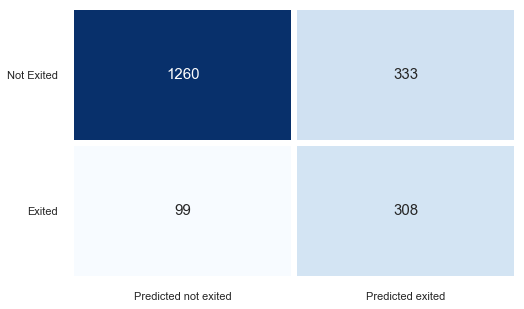

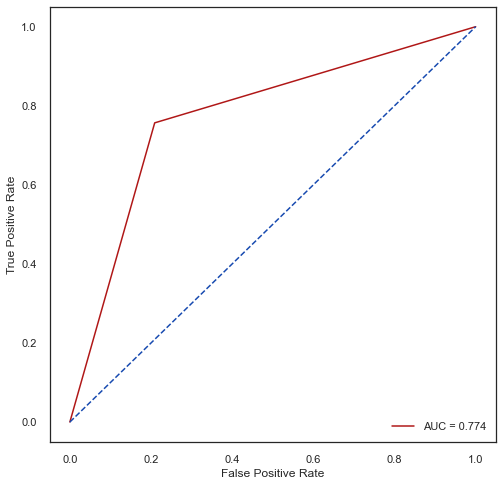

In [92]:
#visualise confusion matrix

cm_ada = confusion_matrix(y_test,y_pred_ada)
plt.figure(figsize = (8, 5))
sns.heatmap(cm_ada, cmap = "Blues", annot = True, fmt = "d", linewidths = 5, cbar = False, annot_kws = {"fontsize": 15},
           yticklabels = ["Not Exited", "Exited"], xticklabels = ["Predicted not exited", "Predicted exited"])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_ada)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = "white")
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = "#b01717", label = "AUC = %0.3f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0, 1], [0, 1], linestyle = "--", color = "#174ab0")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

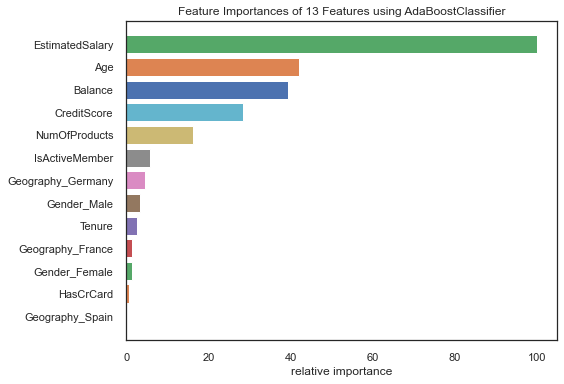

In [89]:
# check on the feature importance 

ada_fi = feature_importances(AdaBoostClassifier(random_state=42,learning_rate= 0.33,n_estimators=380),X_train_scale,y_train,sample_weight=classes_weight)
ada_fi.show()
plt.show()

##### Observation: 

AdaBoost Classifier algorithm have the lowest number of False Negative counts anf the highest count for true positive based on confusion matrix.<br>
After tuning, metric results have been improved in recall anf F1-score but accuracy and precision have decreased.<br>Lastly, log loss have been icreased by 2.45. We will select AdaBoost as our model for this prediction projects as it has the highest recall score among all 3 models.<br>
Estimated salary is the most important feature in AdaBoost Classifier.

#### Model Evaluation

In [90]:
# fitting the training set into the top 3 models with the best parameters after tuning to whow all results in one table

final_results = pd.DataFrame(columns=['model', 'roc', 'logloss', 'accuracy', 'precision', 'recall', 'f1_score'])

best_tuned_3_model = {"RandomForest":RandomForestClassifier(max_depth = 26, n_estimators = 110, criterion = 'entropy',\
                                                            random_state = 42, class_weight = "balanced"), 
                      "LGBM":LGBMClassifier(random_state=42, is_unbalance=True,n_estimators = 410, max_depth = 30,\
                                            learning_rate = 0.30),                                          
                      "AdaBoost":AdaBoostClassifier(n_estimators = 410, learning_rate = 0.33, random_state = 42)}

counter = 0
for k, model in best_tuned_3_model.items():
    best_model = model.fit(X_train_scale, y_train)
    y_pred2 = best_model.predict(X_test_scale)
    final_results.loc[counter, :] = k, roc_auc_score(y_test , y_pred2),\
    log_loss(y_test, y_pred2), accuracy_score(y_test,y_pred2), precision_score(y_test,y_pred2),\
    recall_score(y_test,y_pred2), f1_score(y_test,y_pred2)
    counter += 1

print (final_results)

          model  roc logloss accuracy precision recall f1_score
0  RandomForest 0.70    4.96     0.86      0.75   0.44     0.56
1          LGBM 0.72    5.54     0.84      0.62   0.53     0.57
2      AdaBoost 0.71    4.97     0.86      0.73   0.46     0.57


### Conclusion

The aim of this study was to create classification models for the churn dataset and to predict whether a person abandons us by creating models and to obtain maximum accuracy score in the established models. The work done is as follows:

1) Churn Data Set read.

2) With Exploratory Data Analysis; The data set's structural data were checked. The types of variables in the dataset were examined. Size information of the dataset was accessed. Descriptive statistics of the data set were examined. It was concluded that there were no missing observations and outliers in the data set.

4) During Model Building; Random Forests, XGBoost, LightGBM, SVC, AdaBoost, Bagging, ExtraTress and DecisionTrees like using machine learning models Log loss were calculated. Later Random Forests, LightGBM and AdaBoost hyperparameter optimizations optimized to improve the metric results. 

5) Result; The best model performance is AdaBoost Classifier because it has the better recall and F1 Score and highest in ROC score. Although it log loss is the highest, it have the best true positive and false negative rate compare to others.  

##### Insights/Recommendation: 
1) Based on the feature importance, we know that Age, Estimated Salary and the balance of the money customers deposited into the bank will affect the customer to exit the bank or not.<br>
    - The bank may want to target on the customers who have frequent withdrawal from the bank or monthly regular deposit not reflected for a period, i.e. Salary.<br>
    - The bank will have some client recovery services to keep the customers and get direct feedback from customers to improve their services. 

2) The bank may also focused on those customers that are in the age range to be churn that have shown in the chart and offering better incentives to them in order to minimize churn and keep more customers. 

